In [1]:
# Calculate tuning curves for drifting gratings
import numpy as np
import pandas as pd

import sys
sys.path.append('../')
sys.path.append("../../CPC/dpc")
sys.path.append("../../CPC/backbone")

from python_dict_wrapper import wrap

from tqdm import tqdm
import collections
import torch
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.optimize
import jax

import jax.numpy as jnp
from jax import grad, jit, vmap

import tables
from pathlib import Path

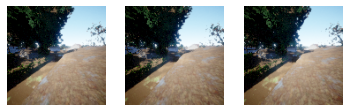

In [3]:
f = tables.open_file('/mnt/e/data_derived/airsim/batch2/nh_fall/2021-02-02T005329/output.h5')
images = f.get_node('/short_videos')[6, :, :, :, :]

for i in range(3):
    plt.subplot(131 + i)
    plt.imshow(images[i, :, :, :].transpose((1, 2, 0)))
    plt.axis('off')

[0.25266962 0.74953086 0.17359842 0.5229949  0.86115193]
[ 1.05704771e-03 -1.46492556e-03  1.49611826e-03  4.96978425e-03
  1.45822196e+00]


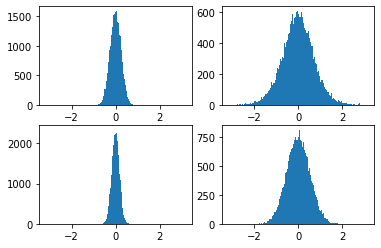

In [4]:
the_paths = sorted(Path('/mnt/e/data_derived/airsim/batch2').glob('*/*/output.h5'))

data = []
for the_path in the_paths:
    f = tables.open_file(str(the_path))
    
    labels = f.get_node('/labels')[:]
    for j in range(len(labels)):
        data.append([labels[j]["heading_pitch"],
     labels[j]["heading_yaw"],
     labels[j]["rotation_pitch"],
     labels[j]["rotation_yaw"],
     labels[j]["speed"]]
    )

data = np.array(data)
for i in range(4):
    plt.subplot(221 + i)
    plt.hist(data[:, i], np.linspace(-np.pi, np.pi, 251))
    
print(np.std(data, axis=0))
print(np.mean(data, axis=0))

# Drifting gratings

In [32]:
features = 'airsim_04'

args = wrap({'features': features,
             'ckpt_root': '../pretrained',
             'slowfast_root': '../../slowfast',
             'ntau': 32,
             'nt': 1,
             'subsample_layers': False})

from fmri_models import get_feature_model

model, hooks, data = get_feature_model(args)

def forward_each(model, hooks, X):
    model.eval()
    latents = collections.defaultdict(lambda: [])
    for i in tqdm(range(X.shape[0])):
        with torch.no_grad():
            if X.shape[2] >= 20:
                X_ = X[i:i+1, 5:-5, :, :]
                
            else:
                X_ = X[i:i+1, :, :, :]
                
            X_ = np.stack([X_, X_, X_], axis=1)
            _ = model(torch.tensor(X_, dtype=torch.float))
        
        for key in hooks.keys():
            Z = hooks[key]
            latents[key].append(Z[:, :, :, Z.shape[3] // 2, Z.shape[4] // 2].mean(axis=2).squeeze())
    
    responses = {}
    for key in hooks.keys():
        responses[key] = np.stack(latents[key], axis=0)
        
    return responses

In [33]:
ntau = 42
radius = 32
ndirections = 16

lambdax = np.array([4, 8, 16, 32, 64])
lambdat = np.array([4, 8, 16, 32])

# Create stimuli that contain all combos that are needed
xi, yi = np.meshgrid(np.arange(-55.5, 56.5), np.arange(-55.5, 56.5))
mask = xi**2 + yi**2 < radius**2
oi = (np.arange(ndirections) / ndirections * 2 * np.pi).reshape((-1, 1, 1, 1))
ti = np.arange(ntau)
ti = ti - ti.mean()

vals = []
stims = []
for lt in lambdat:
    for lx in lambdax:
        ri = (np.cos(oi) * xi.reshape((1, 1, xi.shape[0], xi.shape[1])) - np.sin(oi) * yi.reshape((1, 1, xi.shape[0], xi.shape[1])))
        gratings = mask.reshape((1, 1, xi.shape[0], xi.shape[1])) * np.cos((ri / lx) * 2 * np.pi - ti.reshape((1, -1, 1, 1)) / lt * 2 *np.pi)
        stims.append(gratings)
        vals += [{'orientation': o.squeeze().item(), 'xl': lx, 'tl': lt} for o in oi]

X = np.concatenate(stims, axis=0)
df = pd.DataFrame(vals)

#import napari
#viewer = napari.Viewer()
#viewer.add_image(X)

In [34]:
responses = forward_each(model, hooks, X)

100%|██████████| 320/320 [00:55<00:00,  5.80it/s]


In [22]:
tuning_curve.index

Float64Index([                0.0, 0.39269908169872414,  0.7853981633974483,
               1.1780972450961724,  1.5707963267948966,  1.9634954084936207,
                2.356194490192345,   2.748893571891069,   3.141592653589793,
               3.5342917352885173,  3.9269908169872414,   4.319689898685965,
                 4.71238898038469,   5.105088062083414,   5.497787143782138,
                5.890486225480862,   6.283185307179586],
             dtype='float64')

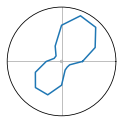

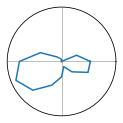

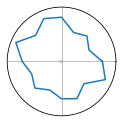

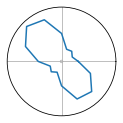

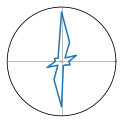

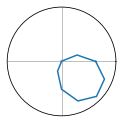

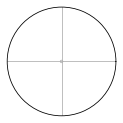

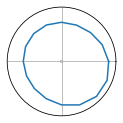

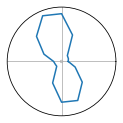

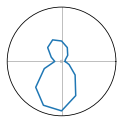

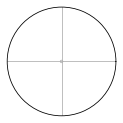

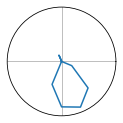

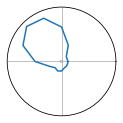

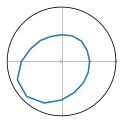

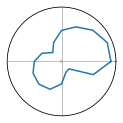

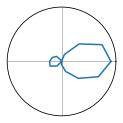

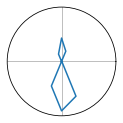

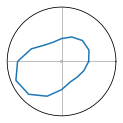

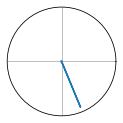

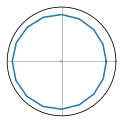

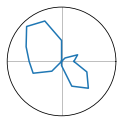

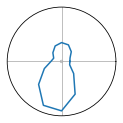

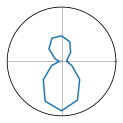

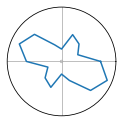

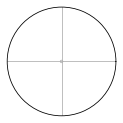

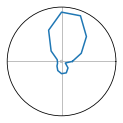

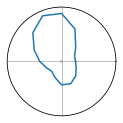

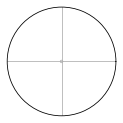

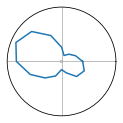

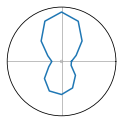

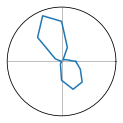

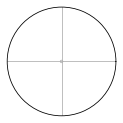

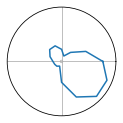

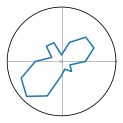

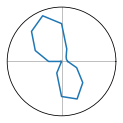

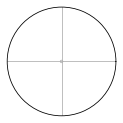

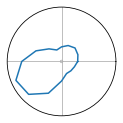

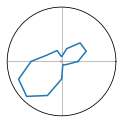

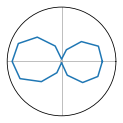

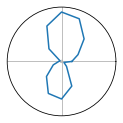

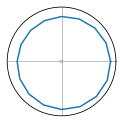

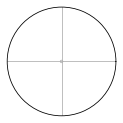

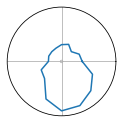

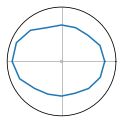

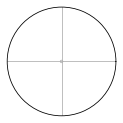

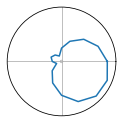

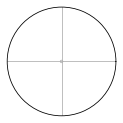

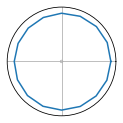

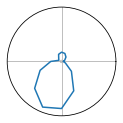

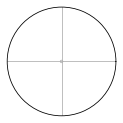

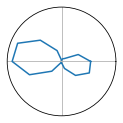

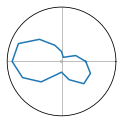

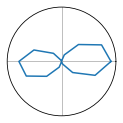

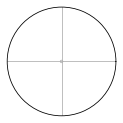

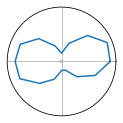

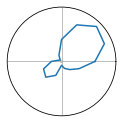

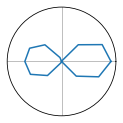

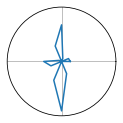

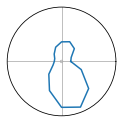

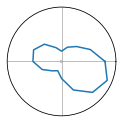

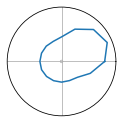

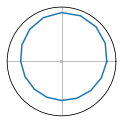

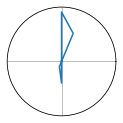

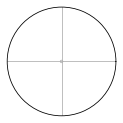

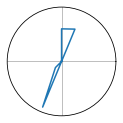

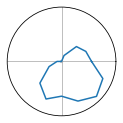

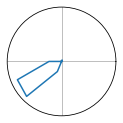

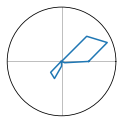

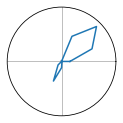

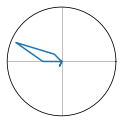

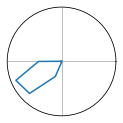

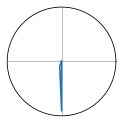

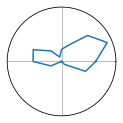

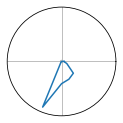

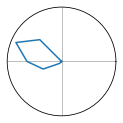

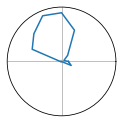

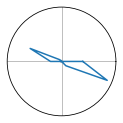

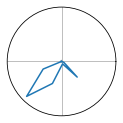

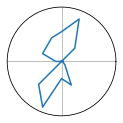

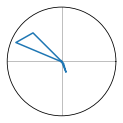

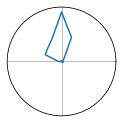

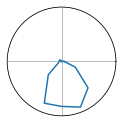

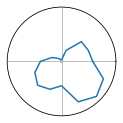

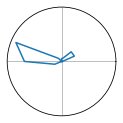

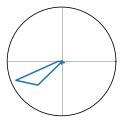

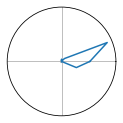

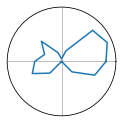

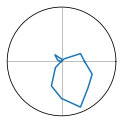

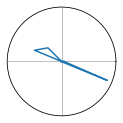

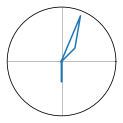

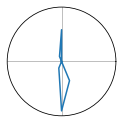

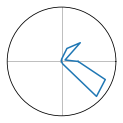

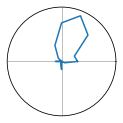

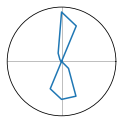

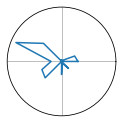

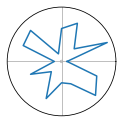

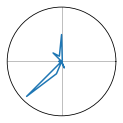

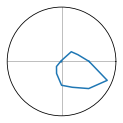

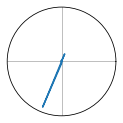

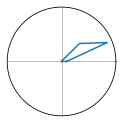

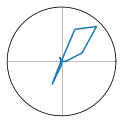

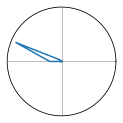

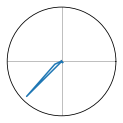

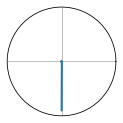

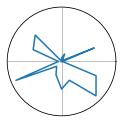

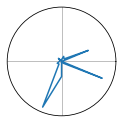

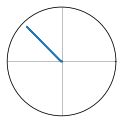

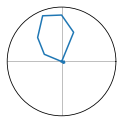

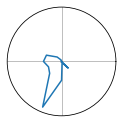

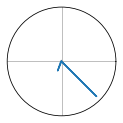

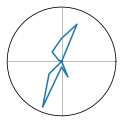

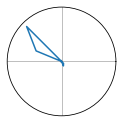

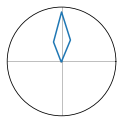

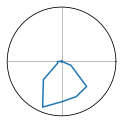

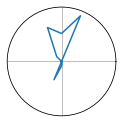

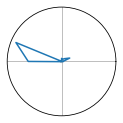

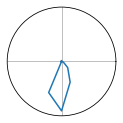

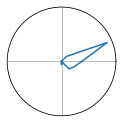

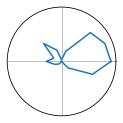

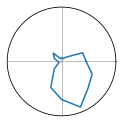

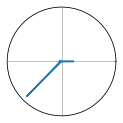

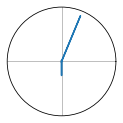

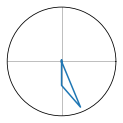

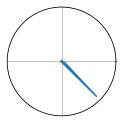

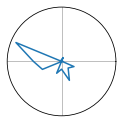

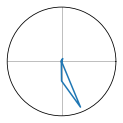

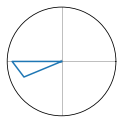

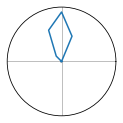

In [35]:
def get_direction_tuning_curve(responses, df):
    df['responses'] = responses
    df['xlXtl'] = df.xl * 100 + df.tl
    R = df.pivot('xlXtl', 'orientation', 'responses')
    bestxt = R.max(axis=1).argmax()
    tuning_curve = R.iloc[bestxt, :]
    tuning_curve = tuning_curve.append(pd.Series(index=[np.pi*2], data=[tuning_curve.values[0]]))
    #print(tuning_curve)
    return tuning_curve


for layer_name, max_filt in [('layer01', 64), ('layer02', 32), ('layer03', 32)]:
    for filt in range(max_filt):
        plt.figure(figsize=(2, 2))
        tuning_curve = get_direction_tuning_curve(responses[layer_name][:, filt], df)
        y = tuning_curve.values

        plt.polar(tuning_curve.index, y * (y > 0))
        plt.ylim((0, 1.1*y.max()))
        plt.xticks([0, np.pi/2, np.pi, np.pi*3/2], ['', '', '', ''])
        plt.yticks([0.025*y.max()], [''])
        fname = f'/home/pmin/paper-assets/tuningcurves/{layer_name}_filt{filt}_tuningcurve.svg'
        plt.savefig(fname)
        fname = f'/home/pmin/paper-assets/tuningcurves/{layer_name}_filt{filt}_tuningcurve.png'
        plt.savefig(fname)
        plt.show()

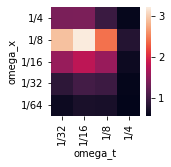

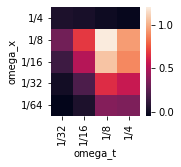

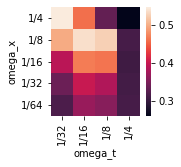

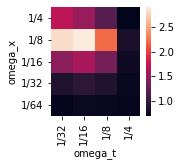

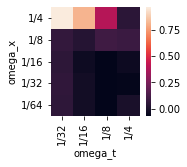

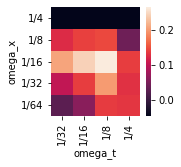

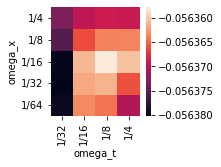

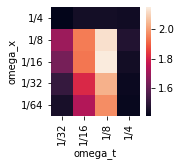

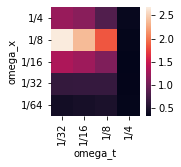

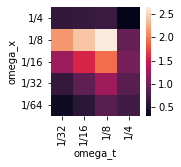

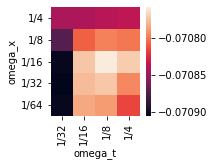

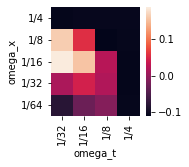

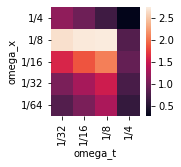

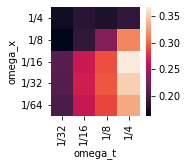

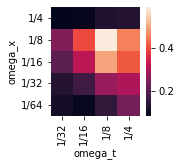

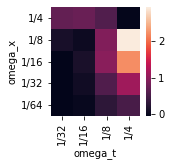

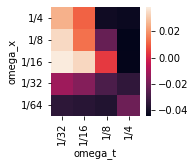

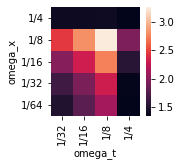

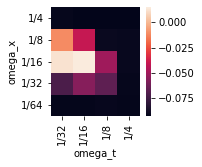

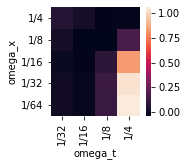

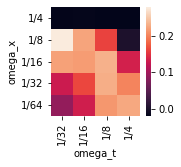

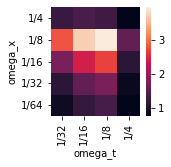

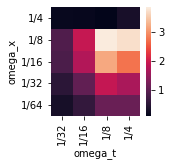

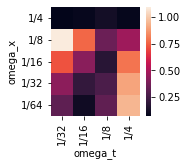

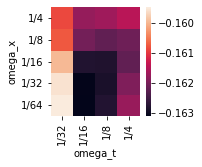

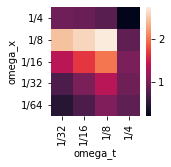

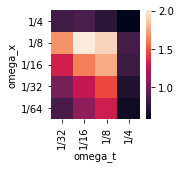

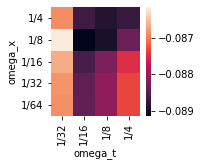

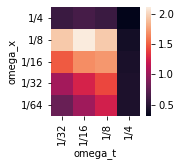

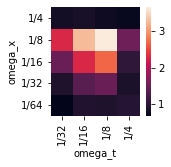

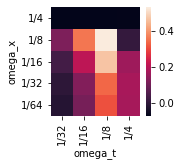

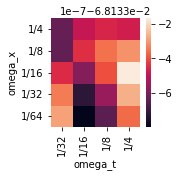

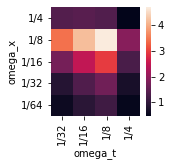

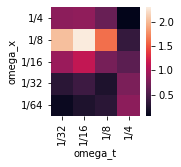

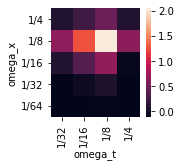

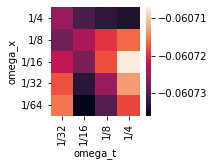

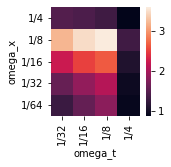

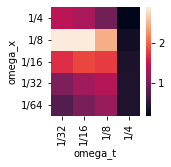

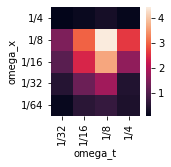

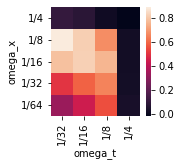

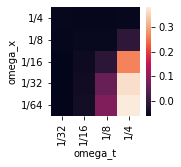

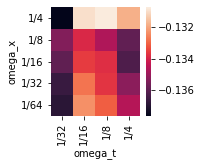

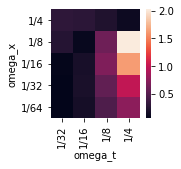

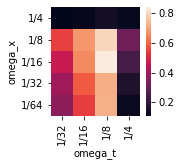

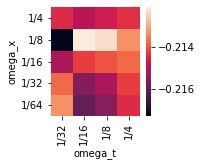

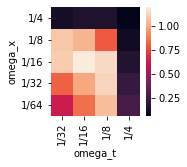

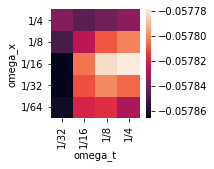

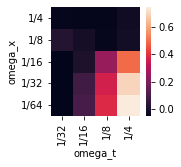

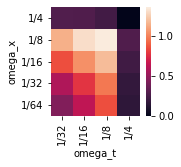

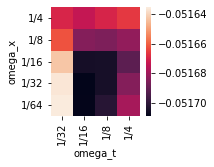

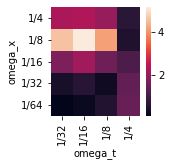

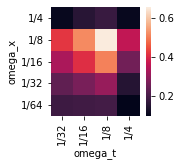

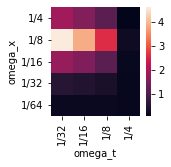

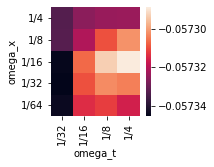

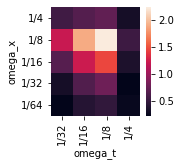

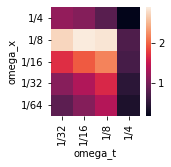

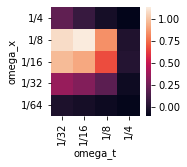

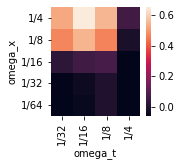

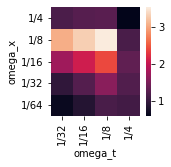

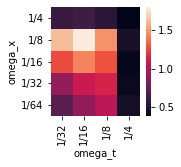

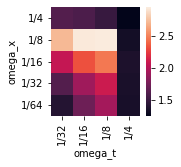

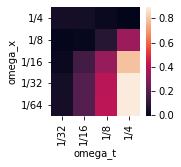

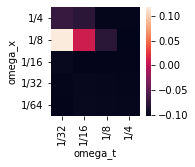

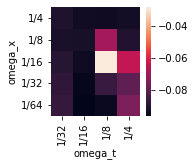

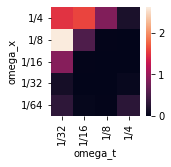

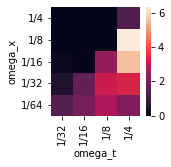

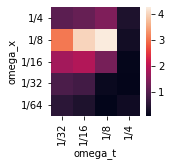

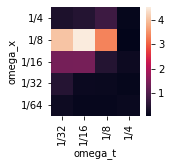

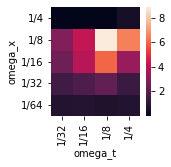

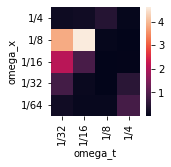

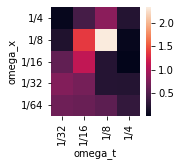

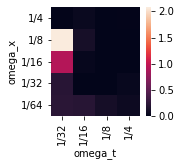

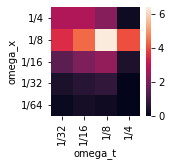

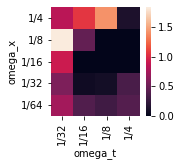

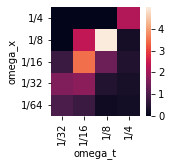

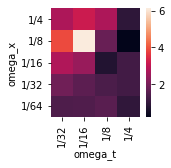

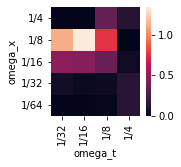

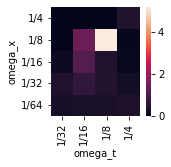

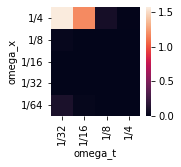

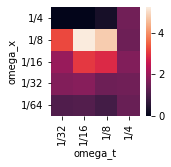

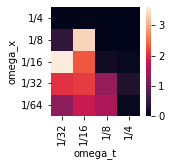

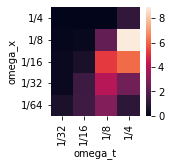

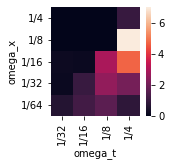

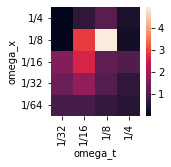

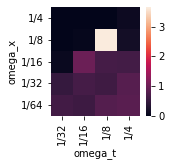

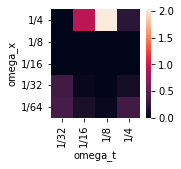

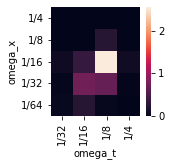

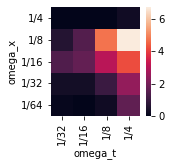

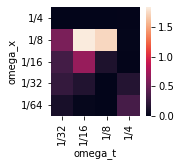

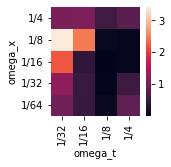

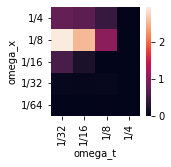

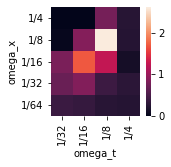

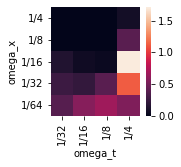

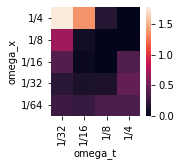

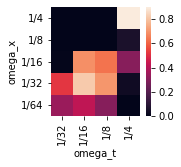

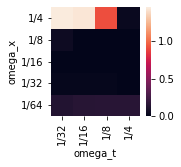

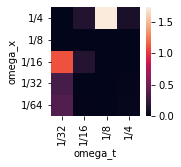

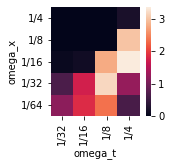

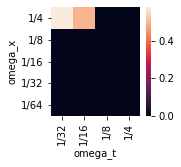

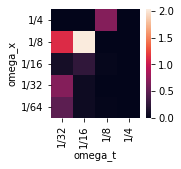

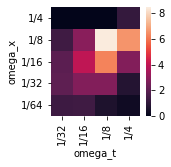

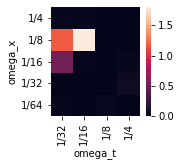

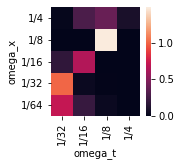

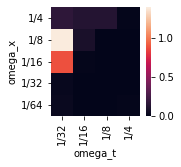

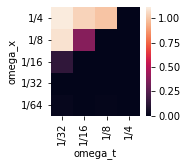

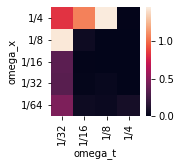

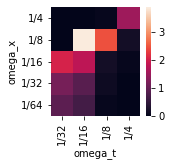

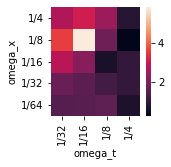

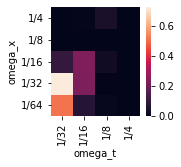

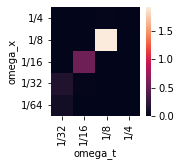

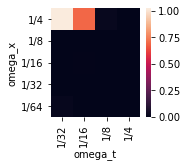

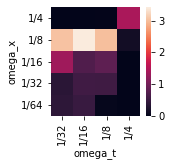

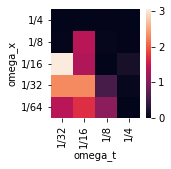

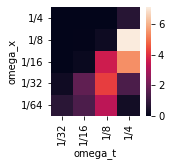

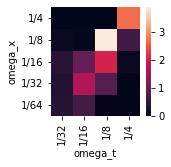

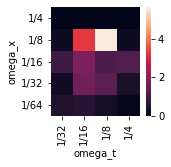

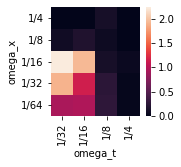

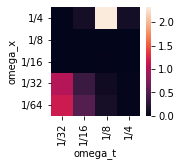

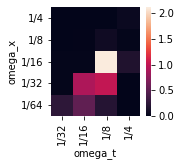

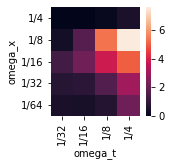

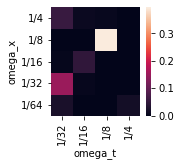

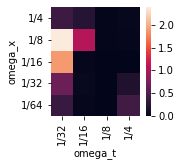

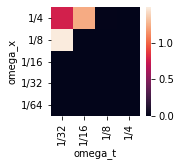

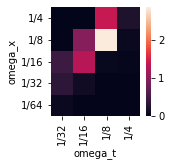

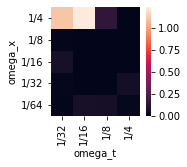

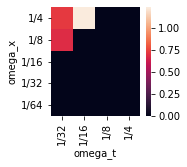

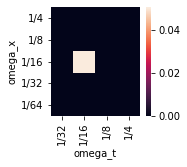

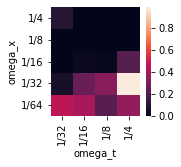

In [190]:
def get_direction_tuning_curve(responses, df):
    df['responses'] = responses
    df['xlXtl'] = df.xl * 100 + df.tl

    R = df.pivot('xlXtl', 'orientation', 'responses')
    
    bestxt = R.max(axis=1).argmax()
    
    tuning_curve = R.iloc[bestxt, :]
    tuning_curve = tuning_curve.append(pd.Series(index=[np.pi*2], data=[tuning_curve.values[0]]))
    return tuning_curve

def get_speed_tuning_curve(responses, df):
    df['responses'] = responses
    df['xlXtl'] = df.xl * 100 + df.tl

    R = df.pivot('xlXtl', 'orientation', 'responses')
    
    besto = R.max(axis=0).argmax()
    
    tuning_curve = R.iloc[:, besto]
    df_ = pd.DataFrame(tuning_curve)
    df_.columns = [
        'responses'
    ]
    df_['xl'] = np.floor(df_.index / 100)
    df_['tl'] = df_.index % 100
    df_['omega_x'] = 1 /df_['xl']
    df_['omega_t'] = 1 /df_['tl']
    df_['tl'] = df_.index % 100
    pivotted = df_.pivot('omega_x', 'omega_t', 'responses')
    return pivotted, df_

def fractionate(tuning_curve):
    xtick = ['1/%d' % x for x in (1 / tuning_curve.columns).astype(np.int)]
    ytick = ['1/%d' % x for x in (1 / tuning_curve.index).astype(np.int)]
    
    plt.xticks(np.arange(len(xtick)) + .5, xtick)
    plt.yticks(np.arange(len(ytick)) + .5, ytick)
    plt.ylim([0, 5])
    #plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5], ['1/64', '1/32', '1/16', '1/8', '1/4', '1/2'])


for layer_name, max_filt in [('layer01', 64), ('layer02', 32), ('layer03', 32)]:
    for filt in range(max_filt):
        #plt.figure(figsize=(2, 2))
    #plt.savefig('/home/pmin/paper-assets/layer02_filt%02d_tuningcurve.svg' % idx)
        plt.figure(figsize=(2, 2))
        tuning_curve, data = get_speed_tuning_curve(responses[layer_name][:, filt], df)
        sns.heatmap(tuning_curve)
        fractionate(tuning_curve)
        plt.savefig(f'/home/pmin/paper-assets/tuningcurves/{layer_name}_filt{filt}_speedtuningcurve.png')
        plt.savefig(f'/home/pmin/paper-assets/tuningcurves/{layer_name}_filt{filt}_speedtuningcurve.svg')
        plt.show()

    #
    #plt.savefig('/home/pmin/paper-assets/layer02_filt%02d_speedtuningcurve.svg' % idx)

In [101]:
max_speeds = []
for j, n in ((1, 64), (2, 32), (3, 32)):
    max_speed = []
    for i in range(n):
        tuning_curve, data = get_speed_tuning_curve(responses[f'layer{j:02}'][:, i], df)
        data['speed'] = data['omega_t'] / data['omega_x']

        # Speed is in pixels per frame
        max_speed.append(data.iloc[data.responses.argmax()].speed)
    max_speeds.append(max_speed)

1.97265625 0.92578125 1.05078125


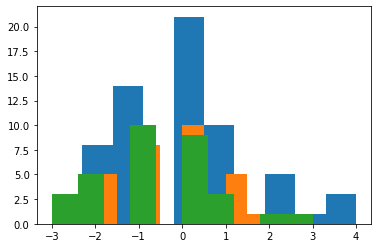

In [110]:
plt.hist(np.log2(max_speeds[0]))
plt.hist(np.log2(max_speeds[1]))
plt.hist(np.log2(max_speeds[2]))
print(np.mean(max_speeds[0]), np.mean(max_speeds[1]), np.mean(max_speeds[2]))

In [ ]:
def speed_tuning_curve(x, A, x0, t0, sigmat, sigmax, Q):
    logtfp = (-Q) * (x[:, 0] - x0) + t0
    R = A * (jnp.exp(-(x[:, 0] - x0) ** 2 / 2 / sigmax
                    -(x[:, 1] - logtfp) ** 2 / 2 / sigmat))
    return R


def jax_curve_fit(f, xdata, ydata, p0):
    """
    Curve fit using jax. Similar interface to scipy.optimize.curve_fit
    
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
    """
    def logprob_fun(params, inputs, targets):
        preds = f(inputs, *params)
        return jnp.sum((preds - targets)**2)
    
    grad_fun = jit(grad(logprob_fun))
    
    p0 = np.array(p0)
    
    E0 = logprob_fun(p0, xdata, ydata)
    
    max_iter = 10000
    max_backtracks = 10
    growth = 2
    backtrack = .1
    alpha = .01
    min_delta = 1e-4
    
    for i in range(max_iter):
        
        # Backtracking line search
        g = grad_fun(p0, xdata, ydata)
        
        alpha = alpha * growth
        
        n = 0
        while n < max_backtracks:
            pp = p0 - alpha * g
            E = logprob_fun(pp, xdata, ydata)
            if E < E0:
                break
                
            alpha = alpha * backtrack
            n += 1
        
        p0 = pp
        if E > E0 - min_delta:
            break
            
        E0 = E
        
    return p0, E

for layer, nums in {'layer01': 64, 'layer02': 32}.items():
    Qs = []
    for idx in range(nums):
        tuning_curve, data = get_speed_tuning_curve(responses[layer][:, idx], df)

        x = np.array([np.log2(data.omega_x), np.log2(data.omega_t)]).T
        y = data.responses.values
        x_ = x[np.argmax(y), :]
        r = speed_tuning_curve(x, *[y.max(), x_[0], x_[1], 2, 2, -1])

        w0 = [y.max(), x_[0], x_[1], 2.0, 2.0, -1.0]
        params0, E0 = jax_curve_fit(speed_tuning_curve, x, y, w0)
        w1 = [y.max(), x_[0], x_[1], 2.0, 2.0, 0.0]
        params1, E1 = jax_curve_fit(speed_tuning_curve, x, y, w1)

        if E0 < E1:
            E = E0
            params = params0
        else:
            E = E1
            params = params1

        EE = ((y - y.mean()) ** 2).sum()
        R2 = 1 - E / EE

        Q = params[-1]
        print([Q.item(), R2.item()])
        
        if R2 > .5:
            Qs.append(Q)
    
    print(np.mean(Qs))
    print(np.median(Qs))

# Plaid indices

In [28]:
# Calculate tuning curves for drifting gratings
ntau = 42
radius = 32
ndirections = 16

lambdax = np.array([4, 8, 16, 32, 64])
lambdat = np.array([4, 8, 16, 32])

# Create stimuli that contain all combos that are needed
xi, yi = np.meshgrid(np.arange(-55.5, 56.5), np.arange(-55.5, 56.5))
mask = xi**2 + yi**2 < radius**2
oi = (np.arange(ndirections) / ndirections * 2 * np.pi).reshape((-1, 1, 1, 1, 1))
ti = np.arange(ntau)
ti = ti - ti.mean()

vals = []
stims = []
del X
for lt in lambdat:
    for lx in lambdax:
        for i in range(4):
            ri0 = (np.cos(oi - np.pi * 3 / 8) * xi.reshape((1, 1, 1, xi.shape[0], xi.shape[1])) - 
                   np.sin(oi - np.pi * 3 / 8) * yi.reshape((1, 1, 1, xi.shape[0], xi.shape[1])))
            ri1 = (np.cos(oi + np.pi * 3 / 8) * xi.reshape((1, 1, 1, xi.shape[0], xi.shape[1])) - 
                   np.sin(oi + np.pi * 3 / 8) * yi.reshape((1, 1, 1, xi.shape[0], xi.shape[1])))
            ri2 = (np.cos(oi) * xi.reshape((1, 1, 1, xi.shape[0], xi.shape[1])) - 
                   np.sin(oi) * yi.reshape((1, 1, 1, xi.shape[0], xi.shape[1])))
            
            if i == 0:
                ri = ri0
            elif i == 1:
                ri = ri1
            elif i == 2:
                ri = ri2
            else:
                ri = ri0
                
            gratings = mask.reshape((1, 1, 1, xi.shape[0], xi.shape[1])) * np.cos((ri / lx) * 2 * np.pi - ti.reshape((1, 1, -1, 1, 1)) / lt * 2 *np.pi)
            
            if i == 3:
                ri = ri1
                gratings += mask.reshape((1, 1, 1, xi.shape[0], xi.shape[1])) * np.cos((ri / lx) * 2 * np.pi - ti.reshape((1, 1, -1, 1, 1)) / lt * 2 *np.pi)
            
            stims.append(gratings)
            
            vals += [{'orientation': o.squeeze().item(), 'xl': lx, 'tl': lt, 'plaid_index': i} for o in oi]

X = np.concatenate(stims, axis=0)
del stims
df = pd.DataFrame(vals)

responses_plaid = forward_each(model, hooks, X.squeeze())

100%|██████████| 1280/1280 [03:58<00:00,  5.37it/s]


In [29]:
def compute_plaid_correlation(responses, df):
    df['responses'] = responses
    df['xlXtl'] = df.xl * 100 + df.tl
    R = df.query('plaid_index == 2').pivot('xlXtl', 'orientation', 'responses')
    bestxt = R.index[R.mean(axis=1).argmax()]
    
    M = df.query(f'xlXtl == {bestxt}').pivot('plaid_index', 'orientation', 'responses')
    
    rc = np.corrcoef(M.iloc[3, :], M.iloc[0, :] + M.iloc[1, :])[0, 1]
    rp = np.corrcoef(M.iloc[3, :], M.iloc[2, :])[0, 1]
    rcp = np.corrcoef(M.iloc[2, :], M.iloc[0, :] + M.iloc[1, :])[0, 1]
    
    Rp = (rp - rc*rcp) / np.sqrt((1 - rc**2)*(1-rcp**2))
    Rc = (rc - rp*rcp) / np.sqrt((1 - rp**2)*(1-rcp**2))
    
    return (Rp, Rc, M)


/home/pmin/anaconda3/envs/dorsal/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/pmin/anaconda3/envs/dorsal/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
<ipython-input-204-0c351df63084>:41: RuntimeWarning: divide by zero encountered in log
  Zp = .5 * np.log((1 + rp) / (1 - rp))
<ipython-input-204-0c351df63084>:73: RuntimeWarning: divide by zero encountered in log
  Zp = .5 * np.log((1 + rp) / (1 - rp))


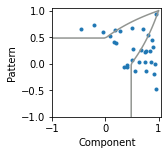

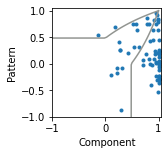

In [204]:

rcs = []
rps = []
for idx in range(32):
    rp, rc, M = compute_plaid_correlation(responses_plaid['layer02'][:, idx], df)
    rps.append(rp)
    rcs.append(rc)

plt.figure(figsize=(2, 2))
plt.plot(rcs, rps, '.')
plt.xlabel('Component')
plt.ylabel('Pattern')
plt.axis('square')
plt.xlim((-1, 1.05))
plt.ylim((-1, 1.05))



#plt.figure(figsize=(4, 2))
#plt.subplot(122)
#plt.hist(np.array(rps)**2 - np.array(rcs) ** 2, np.arange(-10, 11)/10)
#sns.despine()

rp = np.linspace(-1, .999)
Zp = .5 * np.log((1 + rp) / (1 - rp))
t = 1.35
B = np.exp(2 *t * np.sqrt(2 / 13) + 2 *Zp)
B0 = np.exp(2 *t * np.sqrt(2 / 13))
Rc0 = (B0 - 1) / (B0 + 1)

Rc = np.fmax((B - 1) / (B + 1), Rc0)

plt.plot(rp, Rc, 'k-', color='xkcd:gray')
plt.plot(Rc, rp, 'k-', color='xkcd:gray')

plt.savefig('/home/pmin/paper-assets/partial_correlation_layer2.svg')

rcs = []
rps = []
for idx in range(64):
    rp, rc, M = compute_plaid_correlation(responses_plaid['layer01'][:, idx], df)
    rps.append(rp)
    rcs.append(rc)

#plt.subplot(121)
#plt.hist(np.array(rps)**2 - np.array(rcs) ** 2, np.arange(-10, 11)/10)
#sns.despine()
plt.figure(figsize=(2, 2))
plt.plot(rcs, rps, '.')
plt.xlabel('Component')
plt.ylabel('Pattern')
plt.axis('square')
plt.xlim((-1, 1.05))
plt.ylim((-1, 1.05))

rp = np.linspace(-1, .999)
Zp = .5 * np.log((1 + rp) / (1 - rp))
t = 1.35
B = np.exp(2 *t * np.sqrt(2 / 13) + 2 *Zp)
B0 = np.exp(2 *t * np.sqrt(2 / 13))
Rc0 = (B0 - 1) / (B0 + 1)

Rc = np.fmax((B - 1) / (B + 1), Rc0)

plt.plot(rp, Rc, 'k-', color='xkcd:gray')
plt.plot(Rc, rp, 'k-', color='xkcd:gray')

#plt.savefig('/home/pmin/paper-assets/pattern_index_layer1_layer2.svg')
plt.savefig('/home/pmin/paper-assets/partial_correlation_layer1.svg')

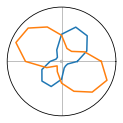

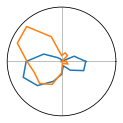

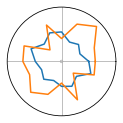

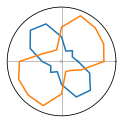

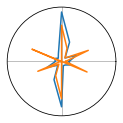

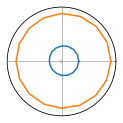

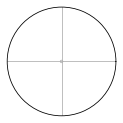

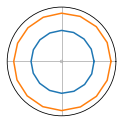

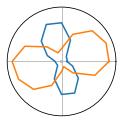

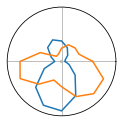

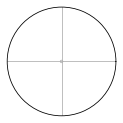

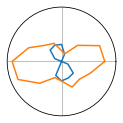

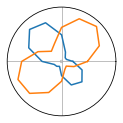

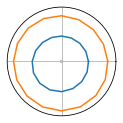

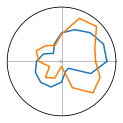

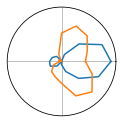

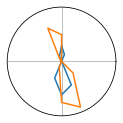

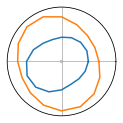

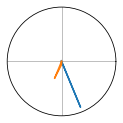

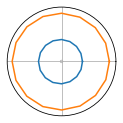

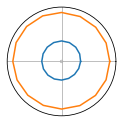

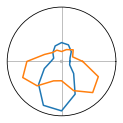

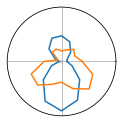

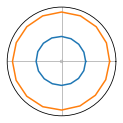

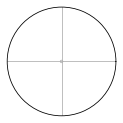

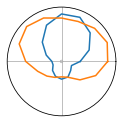

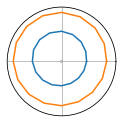

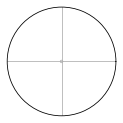

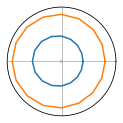

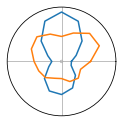

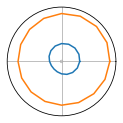

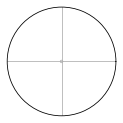

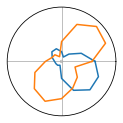

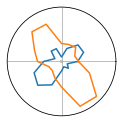

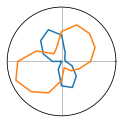

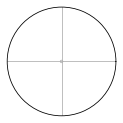

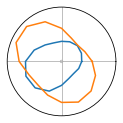

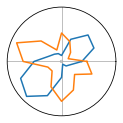

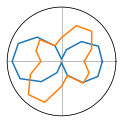

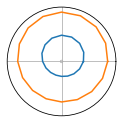

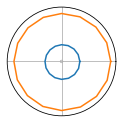

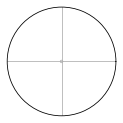

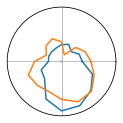

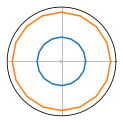

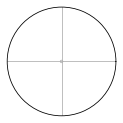

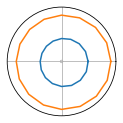

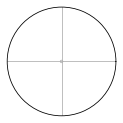

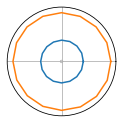

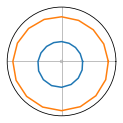

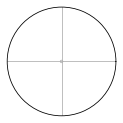

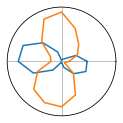

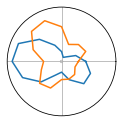

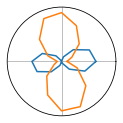

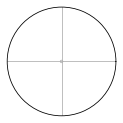

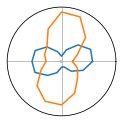

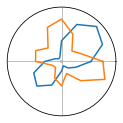

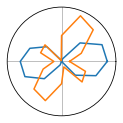

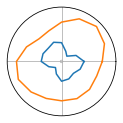

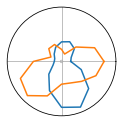

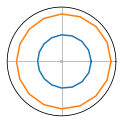

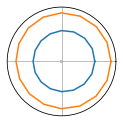

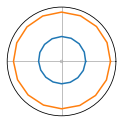

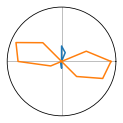

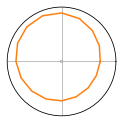

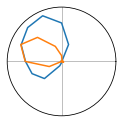

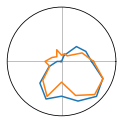

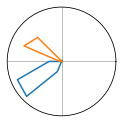

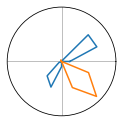

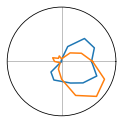

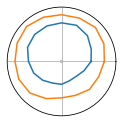

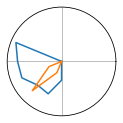

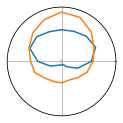

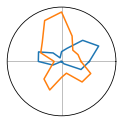

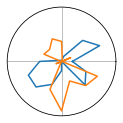

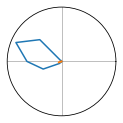

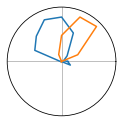

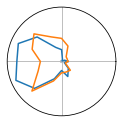

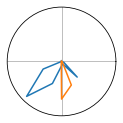

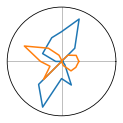

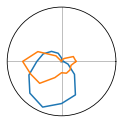

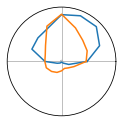

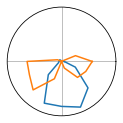

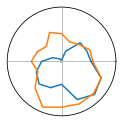

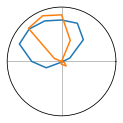

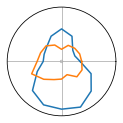

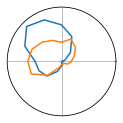

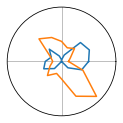

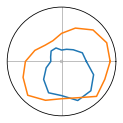

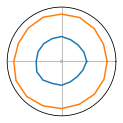

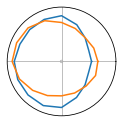

/home/pmin/anaconda3/envs/dorsal/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/pmin/anaconda3/envs/dorsal/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


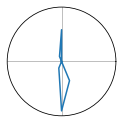

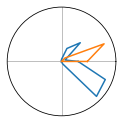

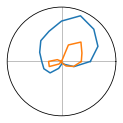

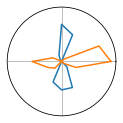

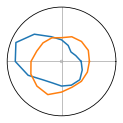

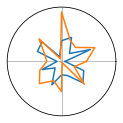

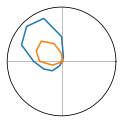

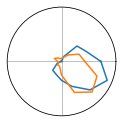

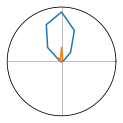

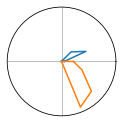

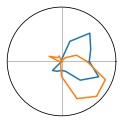

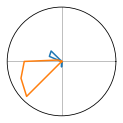

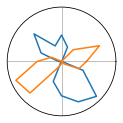

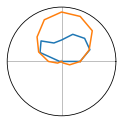

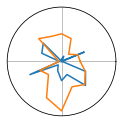

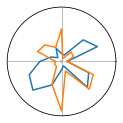

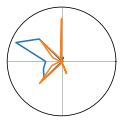

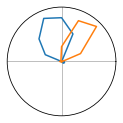

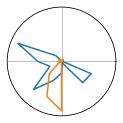

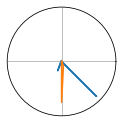

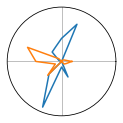

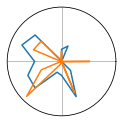

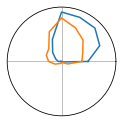

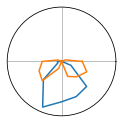

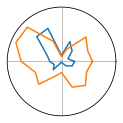

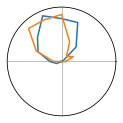

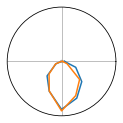

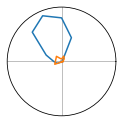

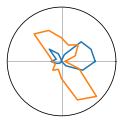

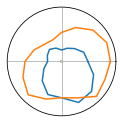

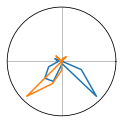

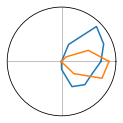

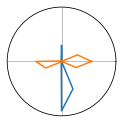

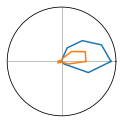

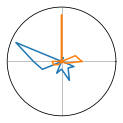

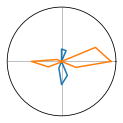

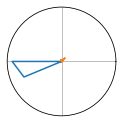

/home/pmin/anaconda3/envs/dorsal/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/pmin/anaconda3/envs/dorsal/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


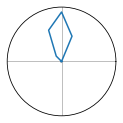

In [31]:
for layer_name, max_filt in [('layer01', 64), ('layer02', 32), ('layer03', 32)]:
    for filt in range(max_filt):
        plt.figure(figsize=(2, 2))
        rp, rc, M = compute_plaid_correlation(responses_plaid[layer_name][:, filt], df)

        maxy = max([M.iloc[2, :].max(), M.iloc[3, :].max()])
        
        for i in [2, 3]:
            y = M.iloc[i, :]
            y = y.append(pd.Series([y[0]], [np.pi*2]))

            plt.polar(y.index, y.values * (y.values > 0))
            plt.ylim((0, 1.1*maxy))
            plt.xticks([0, np.pi/2, np.pi, 3/2*np.pi], ['', '', '', ''])
            plt.yticks([0.025*maxy], [''])
        
        plt.savefig(f'/home/pmin/paper-assets/tuningcurves/pattern_tuning_curve_{layer_name}_filt{filt}.svg')
        plt.savefig(f'/home/pmin/paper-assets/tuningcurves/pattern_tuning_curve_{layer_name}_filt{filt}.png')
        plt.show()

0.998366068886077 1.1679025522958555


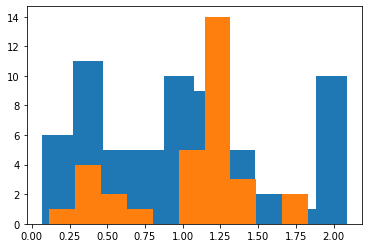

In [111]:
di_v1 = []
di_mt = []

for i in range(64):
    tuning_curve = get_direction_tuning_curve(responses['layer01'][:, i], df)
    y = tuning_curve.values
    y = y[:-1]
    y = y - y.mean()
    
    # Calculate DI
    di_v1.append(1 - y[(y.argmax() + ndirections //2) % len(y)] / y.max())

di_v1 = np.array(di_v1)

for i in range(32):
    tuning_curve = get_direction_tuning_curve(responses['layer02'][:, i], df)
    y = tuning_curve.values
    y = y[:-1]
    y = y - y.mean()
    
    # Calculate DI
    di_mt.append(1 - y[(y.argmax() + ndirections //2) % len(y)] / y.max())
    
di_mt = np.array(di_mt)

plt.hist(di_v1)
plt.hist(di_mt)

print(np.median(di_v1), np.median(di_mt))


In [113]:
tuning_curve

0.000000    0.212518
0.392699    1.221471
0.785398    1.291356
1.178097    0.240949
1.570796    0.969040
1.963495    1.215688
2.356194    0.525292
2.748894    1.454674
3.141593    0.161928
3.534292    1.120861
3.926991    1.413739
4.319690    0.711812
4.712389    0.628985
5.105088    1.181546
5.497787    0.426439
5.890486    0.987386
6.283185    0.212518
dtype: float64

<ipython-input-151-660c4fd7985f>:17: RuntimeWarning: invalid value encountered in double_scalars
  di_v1.append(1 - l/l0)


0.800400081784864 0.402844674014324


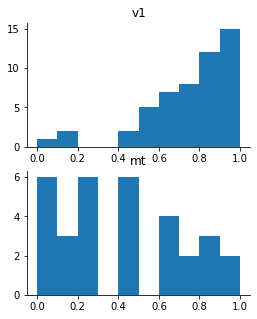

In [151]:
di_v1 = []
di_mt = []

for i in range(64):
    tuning_curve = get_direction_tuning_curve(responses['layer01'][:, i], df)
    y = tuning_curve.values
    y = y[:-1]
    y = y * (y > 0)
    xd, yd = y * np.cos(tuning_curve.index[:-1].values), y * np.sin(tuning_curve.index[:-1].values)
    
    l = np.sqrt(xd.sum()**2 + yd.sum()**2)
    l0 = np.sqrt((xd ** 2) + (yd ** 2)).sum()
    
    assert l0 >= l
    
    # Calculate DI
    di_v1.append(1 - l/l0)

di_v1 = np.array(di_v1)

for i in range(32):
    tuning_curve = get_direction_tuning_curve(responses['layer02'][:, i], df)
    y = tuning_curve.values
    y = y[:-1]
    y = y * (y > 0)
    xd, yd = y * np.cos(tuning_curve.index[:-1].values), y * np.sin(tuning_curve.index[:-1].values)
    
    l = np.sqrt(xd.sum()**2 + yd.sum()**2)
    l0 = np.sqrt((xd ** 2) + (yd ** 2)).sum()
    
    # Calculate DI
    di_mt.append(1 - l/l0)
    
di_mt = np.array(di_mt)

plt.figure(figsize=(4, 5))
plt.subplot(211)
plt.hist(di_v1, np.arange(0, 11) / 10.0)
sns.despine()
plt.title('v1')
plt.subplot(212)
plt.hist(di_mt, np.arange(0, 11) / 10.0)
sns.despine()
plt.title('mt')

print(np.nanmedian(di_v1), np.median(di_mt))

In [136]:
l

0.0

# Responses to complex optic flow

In [152]:
f = tables.open_file('st.h5')
st = f.get_node('/X_report')[:]
st_idx = f.get_node('/Xidx_report')[:]
#responses_supertune = forward_each(model, hooks, X)
st_idx.shape
f.close()

In [153]:
X = np.zeros((216, 40, 112, 112))

for i in range(216):
    X[i, :, :, :] = st[st_idx[i, :], :, :]
    
ns = 216 // 9
X = X[ns*4:ns*5, ...] / 100.0

In [10]:
X.max()

2.55

In [9]:
import napari

viewer = napari.Viewer()
viewer.add_image(X, name='data', colormap='Greys_r')

<Image layer 'data' at 0x7f96580af5b0>

In [155]:
responses = forward_each(model, hooks, X)

100%|██████████| 24/24 [00:02<00:00, 11.00it/s]


<ipython-input-156-b0568f527216>:25: RuntimeWarning: invalid value encountered in true_divide
  B = B / B.sum(axis=0)
<ipython-input-156-b0568f527216>:45: RuntimeWarning: invalid value encountered in true_divide
  B = B / B.sum(axis=0)


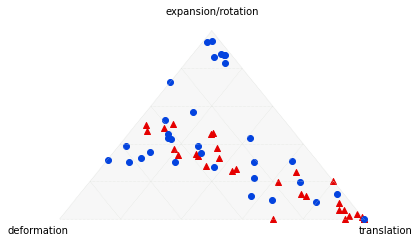

In [156]:
import matplotlib.pyplot as plt

def plot_direction_tuning(y, ax, m):
    idx = np.arange(len(y)+1) % len(y)
    angle = np.arange(len(y)+1) / len(y) * np.pi * 2 
    
    ax.plot(angle, y[idx])
    ax.set_ylim((0, 1.1*m))
    ax.set_xticks([])
    ax.set_yticks([0.025*m])
    ax.set_yticklabels([''])

def plot_each(r):
    fig, axs = plt.subplots(1, 3, subplot_kw=dict(projection="polar"))
    r = r * (r >= 0)
    m = r.max()
    plot_direction_tuning(r[:8], axs[0], m)
    plot_direction_tuning(r[8:16], axs[1], m)
    plot_direction_tuning(r[16:], axs[2], m)
    
#plt.plot(responses['layer03'][:, 4].reshape((-1, 8)).T)
#responses['layer01'].shape
B = responses['layer01'].reshape((3, 8, -1)).mean(axis=1)
B = B * (B > 0)
B = B / B.sum(axis=0)
#B.sum(axis=0)
import ternary

### Scatter Plot
scale = 1
figure, tax = ternary.figure(scale=scale)
#tax.boundary(linewidth=2.0)
tax.gridlines(multiple=.2, color="xkcd:light gray")
fontsize=10
tax.right_corner_label("translation", fontsize=fontsize)
tax.top_corner_label("expansion/rotation", fontsize=fontsize)
tax.left_corner_label("deformation", fontsize=fontsize)
# Plot a few different styles with a legend
tax.boundary(linewidth=0.0)

#s1 = tax.scatter(B.T, marker='v', color='xkcd:blue')

B = responses['layer02'].reshape((3, 8, -1)).mean(axis=1)
B = B * (B > 0)
B = B / B.sum(axis=0)

s2 = tax.scatter(B.T, marker='^', color='xkcd:red')

B = responses['layer03'].reshape((3, 8, -1)).mean(axis=1)
B = B * (B > 0)
B = B / B.sum(axis=0)

#s2 = tax.scatter(B.T, marker='*', color='xkcd:dark green')

B = responses['layer04'].reshape((3, 8, -1)).mean(axis=1)
B = B * (B > 0)
B = B / B.sum(axis=0)

s2 = tax.scatter(B.T, marker='o', color='xkcd:blue')

tax.get_axes().axis('off')
tax.show()

#plt.plot3(B[:, 0], B[:, 1], B[:, 2], '.')
#fig = plt.figure()
#ax = plt.axes(projection='3d')
#ax.plot3D(B[:, 0], B[:, 1], B[:, 2],'k.');
#ax.set_xlim((0, 1))
#ax.set_ylim((0, 1))
#ax.set_zlim((0, 1))

In [158]:
responses['layer01'].shape

(24, 64)

0.9624519170024647 0.6228205850907172


<ipython-input-162-7beb75895f68>:29: RuntimeWarning: invalid value encountered in double_scalars
  di_mt.append(1 - l/l0)


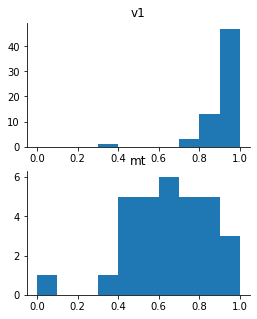

In [162]:
di_v1 = []
di_mt = []
theta = np.arange(8) / 4 * np.pi

for i in range(64):
    tuning_curve = responses['layer01'][:8, i]
    xd, yd = tuning_curve * np.cos(theta), tuning_curve * np.sin(theta)
    
    l = np.sqrt(xd.sum()**2 + yd.sum()**2)
    l0 = np.sqrt((xd ** 2) + (yd ** 2)).sum()
    
    assert l0 >= l
    
    # Calculate DI
    di_v1.append(1 - l/l0)

di_v1 = np.array(di_v1)

for i in range(32):
    tuning_curve = responses['layer02'][:8, i]
    xd, yd = tuning_curve * np.cos(theta), tuning_curve * np.sin(theta)
    
    l = np.sqrt(xd.sum()**2 + yd.sum()**2)
    l0 = np.sqrt((xd ** 2) + (yd ** 2)).sum()
    
    assert l0 >= l
    
    # Calculate DI
    di_mt.append(1 - l/l0)
    
di_mt = np.array(di_mt)

plt.figure(figsize=(4, 5))
plt.subplot(211)
plt.hist(di_v1, np.arange(0, 11) / 10.0)
sns.despine()
plt.title('v1')
plt.subplot(212)
plt.hist(di_mt, np.arange(0, 11) / 10.0)
sns.despine()
plt.title('mt')

print(np.nanmedian(di_v1), np.nanmedian(di_mt))

<ipython-input-119-7687a5dc8da6>:7: RuntimeWarning: invalid value encountered in true_divide
  return (E - T) / (E + T), (R - T) / (R + T), (D - T) / (D + T)


-0.65403104 -0.6858475 -0.29759225
-0.51222384 -0.20701548 -0.06461507
-0.047282238 -0.035251368 0.013407502


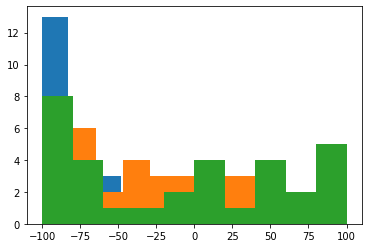

In [119]:
def get_ris(r):
    T = r[:8, :].max(axis=0)
    E = r[[8, 12], :].max(axis=0)
    R = r[[10, 14], :].max(axis=0)
    D = r[16:24, :].max(axis=0)
    
    return (E - T) / (E + T), (R - T) / (R + T), (D - T) / (D + T)
    
ri_e, ri_r, ri_d = get_ris(responses['layer02'].reshape((24, -1)))
plt.hist(100*ri_r)

print(np.nanmedian(ri_e), np.nanmedian(ri_r), np.nanmedian(ri_d))

ri_e, ri_r, ri_d = get_ris(responses['layer03'].reshape((24, -1)))
plt.hist(100*ri_r)

print(np.nanmedian(ri_e), np.nanmedian(ri_r), np.nanmedian(ri_d))

ri_e, ri_r, ri_d = get_ris(responses['layer04'].reshape((24, -1)))
plt.hist(100*ri_r)

print(np.nanmedian(ri_e), np.nanmedian(ri_r), np.nanmedian(ri_d))

(-1.7031591502218504, 9.199691463711808, -5.521510655715592, 5.381339958218066)

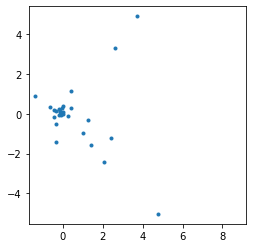

In [137]:
plt.plot(B[:, 0], B[:, 1], '.')
plt.axis('square')

In [33]:
responses['layer02'].shape

(24, 32)

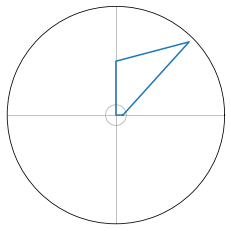

In [71]:
B = responses['layer03']
theta = np.arange(9) / 4 * np.pi

tuning = B[[8, 9, 10, 11, 12, 13, 14, 15, 8], :]
fig, axs = plt.subplots(1, 1, subplot_kw=dict(projection="polar"))

axs.plot(theta, tuning[:, 1])
plt.xticks([0, np.pi / 2, np.pi, np.pi * 1.5], ['', '', '', ''])
plt.yticks([max(tuning[:, 1])*.1], [''])
plt.savefig('/home/pmin/paper-assets/layer3sampletuning.svg')

In [34]:
tuning[:, 1]

array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

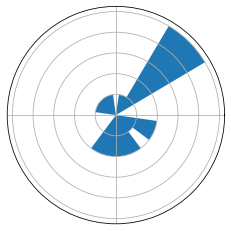

In [30]:
B = responses['layer03'].reshape((24, -1))
theta = np.arange(8) / 4 * np.pi

tuned = B[8:16, :].max(axis=0) > B[:8, :].max(axis=0)
B = np.round(B[8:16, :].T @ np.stack([np.cos(theta), np.sin(theta)], axis=1) * 100)

fig, axs = plt.subplots(1, 1, subplot_kw=dict(projection="polar"))

#axs[0].hist(np.arctan2(B[tuned, 1], B[tuned, 0]) / np.pi * 180)
ns, h = np.histogram(np.arctan2(B[tuned, 1], B[tuned, 0]) / np.pi * 180, np.linspace(-180, 180, 17))
axs.bar(h / 180 * np.pi, np.concatenate([ns, ns[0:1]]), width=.5)
plt.xticks([0, np.pi / 2, np.pi, np.pi * 1.5], ['', '', '', ''])
plt.yticks([0, 1, 2, 3, 4, 5], ['', '', '', '', '', ''])
plt.savefig('/home/pmin/paper-assets/layer3rose.svg')

In [ ]:
from windrose import WindroseAxes

ax = WindroseAxes.from_ax()
ax.bar(ns, ax, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()

# Dots

In [170]:
13*13

169

In [7]:
import napari

v = napari.Viewer()
v.add_image(X)

<Image layer 'X' at 0x7fbd9c5c7e50>

In [10]:
from skimage.draw import disk

from PIL import Image

# Create an hexagonal pattern
def get_one_speed_size(speed, sz):
    superres = 4
    xi2, yi2 = np.meshgrid(np.arange(112 * superres), np.arange(112 * superres))

    dotsx = []
    dotsy = []

    spacing = sz*2

    dot_patterns = []
    for o in np.arange(0, 16) / 8 * np.pi:
        ims = []
        for dt in range(22):
            img = np.zeros((112 * superres, 112 * superres))
            for i in range(112 // spacing + 1):
                for j in range(112 // spacing * 3 // 2):
                    if j % 2 == 0:
                        dotx = i * spacing
                    else:
                        dotx = (i + .5) * spacing 

                    doty = j * spacing * np.sqrt(3) / 2

                    dotx += np.cos(o) * dt * speed
                    doty -= np.sin(o) * dt * speed

                    rr, cc = disk((doty * superres, dotx * superres), sz / 3 * superres, shape=img.shape)
                    img[rr, cc] = 255

            img = img.reshape((112, superres, 112, superres)).mean(3).mean(1)
            ims.append(img)
        ims = np.stack(ims, axis=0)
        dot_patterns.append(ims)
    dot_patterns = np.stack(dot_patterns, axis=0)

    rg = slice(112 // 2 - 8, 112 // 2 + 8)
    core_patterns = dot_patterns[:, :, rg, rg]

    dx = 8
    n = 2
    
    patches = []
    for xc in np.arange(dx*n, 112-8-dx*n, 8):
        for yc in np.arange(dx*n, 112-8-dx*n, 8):
            ims = np.zeros(dot_patterns.shape)
            rgy = slice(yc, yc + 16)
            rgx = slice(xc, xc + 16)

            ims[:, :, rgy, rgx] = core_patterns
            patches.append(ims)
    patches = np.concatenate(patches, axis=0)
    responses = forward_each(model, hooks, patches / 100.0)
    return responses
    
results = []
for sz in [3, 5]:
    for i, speed in enumerate([.5, 1, 2]):
        results.append(get_one_speed_size(speed, sz))

100%|██████████| 1296/1296 [00:58<00:00, 22.15it/s]


0.08678756768650679


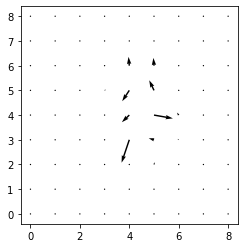

In [28]:
no = 16

def quiver_plot(results, layer, num):
    rs = []
    for r in results:
        rs.append(r[layer][:, num])
        
    w = np.stack(rs, axis=1)
    idx = w.max(axis=0).argmax()
    w = np.max(w, axis=1)#[:, idx]
    
    side = int(np.sqrt(w.size // no))
    
    w = w.reshape((-1, no))
    theta = np.arange(no) / no * 2 * np.pi
    B = np.stack([np.cos(theta), np.sin(theta)], axis=1)
    responses = (w @ B).reshape((side, side, 2))
    responses = responses / np.sqrt((responses ** 2).sum(axis=2, keepdims=True)).max() / side
    print(responses.max())
    plt.quiver(responses[:, :, 0], responses[:, :, 1], scale=1)
    plt.axis('square')
    
#_ = plt.plot(responses['layer00'][:, 0].reshape((-1, 16)).T)


#plt.imshow((responses['layer02'][:, 2]).reshape((-1, 16)).sum(axis=1).reshape((13, 13)))
#plt.colorbar()
quiver_plot(results, 'layer02', 12)

In [9]:
from skimage.draw import disk

from PIL import Image

# Create an hexagonal pattern
def get_two_interactions_one_speed(speed):
    superres = 4
    xi2, yi2 = np.meshgrid(np.arange(112 * superres), np.arange(112 * superres))

    dotsx = []
    dotsy = []

    spacing = 8

    dot_patterns = []
    for o in np.arange(0, 8) / 4 * np.pi:
        ims = []
        for dt in range(22):
            img = np.zeros((112 * superres, 112 * superres))
            for i in range(112 // spacing + 1):
                for j in range(112 // spacing * 3 // 2):
                    if j % 2 == 0:
                        dotx = i * spacing
                    else:
                        dotx = (i + .5) * spacing 

                    doty = j * spacing * np.sqrt(3) / 2

                    dotx += np.cos(o) * dt * speed
                    doty -= np.sin(o) * dt * speed

                    rr, cc = disk((doty * superres, dotx * superres), 1.5 * superres, shape=img.shape)
                    img[rr, cc] = 255

            img = img.reshape((112, superres, 112, superres)).mean(3).mean(1)
            ims.append(img)
        ims = np.stack(ims, axis=0)
        dot_patterns.append(ims)
    dot_patterns = np.stack(dot_patterns, axis=0)

    rg = slice(112 // 2 - 8, 112 // 2 + 8)
    core_patterns = dot_patterns[:, :, rg, rg]

    patches = []
    
    pairs = []
    for i in [-2, 0, 2]:
        for j in [-2, 0, 2]:
            pairs.append((i, j))
            
    ppairs = []
    for i, p0 in enumerate(pairs):
        for j, p1 in enumerate(pairs):
            if i != j:
                ppairs.append((p1, p0))
    
    for (x0, y0), (x1, y1) in ppairs:
        ims = np.zeros((dot_patterns.shape[0], ) + dot_patterns.shape)
        
        xc = 112 // 2 - 8 + x0 * 8
        yc = 112 // 2 - 8 + y0 * 8
        
        rgy = slice(yc, yc + 16)
        rgx = slice(xc, xc + 16)
        
        ims[:, :, :, rgy, rgx] = core_patterns.reshape((1, ) + core_patterns.shape)
        
        xc = 112 // 2 - 8 + x1 * 8
        yc = 112 // 2 - 8 + y1 * 8
        
        rgy = slice(yc, yc + 16)
        rgx = slice(xc, xc + 16)
        
        ims[:, :, :, rgy, rgx] = core_patterns.reshape((core_patterns.shape[0], 1, ) + core_patterns.shape[1:])
        
        patches.append(ims.reshape((-1, ) + dot_patterns.shape[1:]))
        
    patches = np.concatenate(patches, axis=0)
    responses = forward_each(model, hooks, patches / 100.0)
    return responses
    
results = []
for i, speed in enumerate([.5, 1, 2, 4]):
    results.append(get_two_interactions_one_speed(speed))

#X = get_two_interactions_one_speed(.5)

100%|██████████| 4608/4608 [03:06<00:00, 24.76it/s]


In [178]:
import napari

v = napari.Viewer()
v.add_image(X)

<Image layer 'X' at 0x7fa7a8890e80>

In [22]:
combos = []
for l in range(9):
    for k in range(9):
        for j in range(8):
            for i in range(8):
                if k == l:
                    continue
                combos.append({'x0': l, 'o0': j, 'x1': k, 'o1': i})
                
df = pd.DataFrame(combos)
df.head(5)

,x0,o0,x1,o1
0,0,0,1,0
1,0,0,1,1
2,0,0,1,2
3,0,0,1,3
4,0,0,1,4


In [20]:
results[0]['layer02'].shape

(4608, 32)

0.046911723607185964


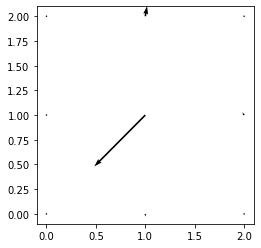

In [36]:
def quiver_plot2d(results, layer, num):
    rs = []
    for r in results:
        rs.append(r[layer][:, num])
        
    w = np.stack(rs, axis=1)
    idx = w.max(axis=0).argmax()
    
    w = w[:, idx]
    
    #w = quiver_plot2d(results, 'layer02', 0)
    df['r'] = w

    tuning_curves = []
    for pos in range(9):
        tuning_curves.append(
            ((df[(df.x0 == pos)].groupby(['o0']).mean() + df[(df.x1 == pos)].groupby(['o1']).mean()) / 2).r.values
        )

    w = np.stack(tuning_curves, axis=0)
    no = 8
    
    side = int(np.sqrt(w.size // no))
    
    w = w.reshape((-1, no))
    theta = np.arange(no) / no * 2 * np.pi
    B = np.stack([np.cos(theta), np.sin(theta)], axis=1)
    responses = (w @ B).reshape((side, side, 2))
    responses = responses / np.sqrt((responses ** 2).sum(axis=2, keepdims=True)).max() / side
    print(responses.max())
    plt.quiver(responses[:, :, 0], responses[:, :, 1], scale=1)
    plt.axis('square')
    
    #return w

quiver_plot2d(results, 'layer02', 12)

In [11]:
results

[{'layer00': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  'layer01': array([[ 0.53942454, -0.08625251,  0.27965567, ..., -0.00820218,
          -0.09978094, -0.09213497],
         [ 0.53942454, -0.08625251,  0.27965567, ..., -0.00820218,
          -0.09978094, -0.09213497],
         [ 0.53942454, -0.08625251,  0.27965567, ..., -0.00820218,
          -0.09978094, -0.09213497],
         ...,
         [ 0.53942454, -0.08625251,  0.27965567, ..., -0.00820218,
          -0.09978094, -0.09213497],
         [ 0.53942454, -0.08625251,  0.27965567, ..., -0.00820218,
          -0.09978094, -0.09213497],
         [ 0.53942454, -0.08625251,  0.27965567, ..., -0.00820218,
          -0.09978094, -0.09213497]], dtype=float32),
  'layer02': array([[0.7826356 , 0.7941558 , 0.48963